In [1794]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import umap.umap_ as umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_rows", 3000)
pd.set_option('use_inf_as_na', True)

In [1795]:
def_vectors = pd.read_pickle("../data/defender_clusters/defender_vectors.pkl")

In [1796]:
def_vectors[def_vectors['player_name'].str.contains("Vert")]

,player_name,team,position,footedness,matches_played,passes,accpass,progaccpass,proginaccpass,accpassloc,inaccpassloc,progaccpassloc,proginaccpassloc,accpassvaep,inaccpassvaep,progaccpassvaep,proginaccpassvaep,accpassoff,inaccpassoff,progaccpassoff,proginaccpassoff,accpassdef,inaccpassdef,progaccpassdef,proginaccpassdef,progaccidx,proginaccidx,offsum_regionwise,vaepsum_regionwise,prog_acc_region_per_pass,vaep_acc_region_per_pass,prog_inacc_region_per_pass,vaep_inacc_region_per_pass,off_acc_region_per_pass,off_inacc_region_per_pass,def_acc_region_per_pass,def_inacc_region_per_pass,vaep_avgcontri,vaep_stdcontri,off_avgcontri,off_stdcontri,progpreference_per_region,progaccuracy_per_region,total_off_region_per_pass,off_val_opp_sum,off_val_opp_avg
156,JanVertonghen,Tottenham Hotspur,LB,left,1.0,78,69,14,6,"[[[58.24, 64.6], [47.84, 57.8]], [[67.6, 63.24...","[[[59.28, 63.92], [90.48, 41.48]], [[52.0, 60....","[[[67.6, 63.24], [80.08, 61.88]], [[54.08, 63....","[[[59.28, 63.92], [90.48, 41.48]], [[73.84, 65...","[-0.0028125690296292305, 0.005345508921891451,...","[0.0002524210140109062, -0.004603143781423569,...","[0.005345508921891451, 0.00448447372764349, 0....","[0.0002524210140109062, -0.005919557064771652,...","[-0.002592453733086586, 0.005652479827404022, ...","[0.001600220799446106, -0.0034494996070861816,...","[0.005652479827404022, 0.004444997292011976, 0...","[0.001600220799446106, -0.0040491484105587006,...","[-0.00022011541295796633, -0.00030697078909724...","[-0.0013477997854351997, -0.001153644174337387...","[-0.0003069707890972495, 3.9476435631513596e-0...","[-0.0013477997854351997, -0.001870408421382308...",[14],[6],"[0.044534915359690785, 0.8159284058492631, 1.1...","[0.014720126986503601, 0.7983978851698339, 1.1...","[0, 0, 0, 0, 57.14, 28.57, 7.14, 7.14]","[0, 0, 0, 0, 5.889438631129451, 4.081242834217...","[0, 0, 0, 0, 50.0, 33.33, 16.67, 0]","[0, 0, 0, 0, -4.355990948776404, -2.8335680253...","[0, 0, 0, 0, 5.827606189996004, 4.027655930258...","[0, 0, 0, 0, -2.9115028058489165, -1.224463805...","[0, 0, 0, 0, 0.06183226651046425, 0.0535869621...","[0, 0, 0, 0, -1.4444882981479168, -1.609104103...","[1.0315699009010901, 0.5225336165196528, 0.613...","[0.0, 0.0, 0.0, 0.0]","[1.0261960550720701, 0.5197276349805706, 0.601...","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 55.0, 30.0, 10.0, 5.0]","[0, 0, 0, 0, 72.73, 66.67, 50.0, 100.0]","[0, 0, 0, 0, 3.4442128274928443, 2.27694935165...",NaN,NaN
157,JanVertonghen,Tottenham Hotspur,LCB,left,11.0,705,629,191,44,"[[[32.24, 53.04], [30.16, 23.8]], [[71.76, 54....","[[[64.48, 48.28], [97.76, 63.92]], [[73.84, 40...","[[[59.28, 51.68], [63.44, 33.32]], [[69.68, 51...","[[[64.48, 48.28], [97.76, 63.92]], [[73.84, 40...","[0.00028056418523192406, 0.0017307291273027658...","[-0.008233223110437393, -0.008894246071577072,...","[0.0034494372084736824, 0.02475588023662567, 0...","[-0.008233223110437393, -0.008894246071577072,...","[-0.000399809330701828, 0.0017198743298649788,...","[-0.0074471584521234035, -0.007266614586114883...","[0.003780239261686802, 0.021988609805703163, -...","[-0.0074471584521234035, -0.007266614586114883...","[0.0006803735159337521, 1.0854797437787056e-05...","[-0.000786065123975277, -0.001627631951123476,...","[-0.00033080216962844133, 0.002767270896583795...","[-0.000786065123975277, -0.001627631951123476,...","[23, 38, 64, 79, 93, 106, 111, 116, 123, 173, ...","[7, 11, 12, 17, 23, 27, 28, 33, 37, 41, 44]","[-0.8292573258513585, 0.6530550491297618, 0.59...","[-0.9291653742548078, 0.5892201965907589, 0.56...","[2.62, 0, 0.52, 1.57, 53.93, 20.94, 10.99, 9.42]","[8.72106053866446, 0, 1.484508509747684, 2.962...","[4.55, 2.27, 0, 0, 31.82, 27.27, 25.0, 9.09]","[1.0606406722217798, 1.947697950527072, 0, 0, ...","[3.9240263868123293, 0, 1.354206819087267, 1.8...","[0.4226094461046159, 3.8113954942673445, 0, 0,...","[4.797034012153745, 0, 0.13030169066041708, 1....","[0.638031167909503, -1.8636975437402725, 0, 0,...","[0.9536223873850377, 0.7194567496984325, 0.7

In [1797]:
def_vectors = def_vectors[def_vectors['progaccpass'] + def_vectors['proginaccpass'] > 20]

In [1798]:
def_vectors.reset_index(inplace=True)
def_vectors.drop(['index'],inplace=True,axis=1)

In [1799]:
def_vectors['progaccpass_pm']=def_vectors['progaccpass']/def_vectors['matches_played']
def_vectors['proginaccpass_pm']=def_vectors['proginaccpass']/def_vectors['matches_played']

In [1800]:
cols = ['player_name','team','position','footedness','progaccpass_pm','proginaccpass_pm','progpreference_per_region','progaccuracy_per_region','total_off_region_per_pass','off_avgcontri','off_val_opp_avg']
def_vectors_fil = def_vectors[cols]

In [1801]:
def_vectors_foot_sep = pd.get_dummies(def_vectors_fil,prefix=['foot'],columns=['footedness'])

In [1802]:
def_vectors_foot_sep['position'].value_counts()

R_CB    49
L_CB    45
RB      45
LB      41
RCB     28
LCB     28
CB      20
LWB      3
RWB      2
Name: position, dtype: int64

In [1803]:
def ind_cols(df):
    df1 = pd.DataFrame([sub_list[4:] for sub_list in df['progpreference_per_region'].tolist()], columns = ['att_LF_pref','att_LC_pref','att_RC_pref','att_RF_pref'])
    df2 = pd.DataFrame([sub_list[4:] for sub_list in df['total_off_region_per_pass'].tolist()], columns = ['att_LF_off','att_LC_off','att_RC_off','att_RF_off'])
    df3 = pd.DataFrame([sub_list[4:] for sub_list in df['progaccuracy_per_region'].tolist()], columns = ['att_LF_acc','att_LC_acc','att_RC_acc','att_RF_acc'])
    df4 = pd.DataFrame(df['off_avgcontri'].tolist(), columns = ['att_LF_offcontri','att_LC_offcontri','att_RC_offcontri','att_RF_offcontri'])
    df= pd.concat([df,df1,df3,df2,df4], axis = 1)
    df.drop(['progpreference_per_region','progaccuracy_per_region','total_off_region_per_pass','off_avgcontri'], axis = 1, inplace = True)
    return df

In [1804]:
def_vectors_ind_footsep = ind_cols(def_vectors_foot_sep)

In [1805]:
def_vectors_ind_footsep.head()

,player_name,team,position,progaccpass_pm,proginaccpass_pm,off_val_opp_avg,foot_left,foot_right,att_LF_pref,att_LC_pref,att_RC_pref,att_RF_pref,att_LF_acc,att_LC_acc,att_RC_acc,att_RF_acc,att_LF_off,att_LC_off,att_RC_off,att_RF_off,att_LF_offcontri,att_LC_offcontri,att_RC_offcontri,att_RF_offcontri
0,AaronCresswell,West Ham United,LB,6.142857,6.714286,0.026267,1,0,44.44,30.00,6.67,12.22,57.50,33.33,66.67,27.27,1.854026,2.507129,22.137616,-1.200041,0.949369,0.983086,0.757630,0.933282
1,AaronCresswell,West Ham United,LCB,9.200000,4.550000,0.154344,1,0,56.73,25.09,9.09,5.09,78.21,52.17,60.00,50.00,4.098572,10.470576,19.408194,2.985546,0.955638,0.787810,0.797654,0.757382
2,AaronWanBissaka,Crystal Palace,RB,5.571429,2.857143,0.232525,0,1,3.39,6.78,16.95,64.41,50.00,50.00,70.00,68.42,-2.041411,21.571248,36.222678,3.355633,0.934154,0.699378,0.804557,0.847289
3,AdamSmith,AFC Bournemouth,LB,9.000000,3.333333,0.485561,0,1,29.73,27.03,18.92,21.62,90.91,50.00,57.14,87.50,5.263003,3.967432,17.062913,5.561234,0.933989,0.678025,0.591580,0.944362
4,AdamSmith,AFC Bournemouth,RB,7.100000,3.500000,NaN,0,1,5.66,6.60,28.30,57.55,83.33,71.43,63.33,65.57,2.350818,11.183411,9.346241,3.238597,0.923922,0.723191,0.776001,0.919862


In [1806]:
scaler = StandardScaler()
feat_scaled=scaler.fit_transform(def_vectors_ind_footsep[def_vectors_ind_footsep.columns.difference(['player_name','team','position','off_val_opp_avg','foot_left'])].values)


In [1807]:
def_vectors_footsep_scaled = pd.concat([def_vectors_ind_footsep[['player_name','team','position','off_val_opp_avg']],pd.DataFrame(feat_scaled,columns=def_vectors_ind_footsep.columns.difference(['player_name','team','position','off_val_opp_avg','foot_left']))],axis=1)


In [1808]:
def_vectors_footsep_scaled.head()

,player_name,team,position,off_val_opp_avg,att_LC_acc,att_LC_off,att_LC_offcontri,att_LC_pref,att_LF_acc,att_LF_off,att_LF_offcontri,att_LF_pref,att_RC_acc,att_RC_off,att_RC_offcontri,att_RC_pref,att_RF_acc,att_RF_off,att_RF_offcontri,att_RF_pref,foot_right,progaccpass_pm,proginaccpass_pm
0,AaronCresswell,West Ham United,LB,0.026267,-1.411576,-0.876515,3.151266,1.433573,-0.537443,-0.215686,-0.084316,1.086306,0.217837,1.285909,0.287237,-1.350517,-1.658563,-0.865992,-0.022101,-0.851988,-1.684706,-0.617849,2.107259
1,AaronCresswell,West Ham United,LCB,0.154344,-0.478425,0.038441,0.626974,0.845931,0.374843,0.515579,0.060268,1.774891,-0.126425,0.995958,0.822473,-1.063413,-0.656081,0.081097,-1.005588,-1.246466,-1.684706,0.047247,0.619972
2,AaronWanBissaka,Crystal Palace,RB,0.232525,-0.585906,1.313847,-0.516171,-1.345457,-0.867822,-1.484806,-0.435248,-1.213649,0.389710,2.782187,0.914782,-0.130920,0.156314,0.164838,-0.502904,2.035502,0.593575,-0.742166,-0.543353
3,AdamSmith,AFC Bournemouth,LB,0.485561,-0.585906,-0.708734,-0.792201,1.078116,0.934284,0.894947,-0.439047,0.262132,-0.274040,0.746815,-1.933281,0.102797,0.997817,0.663907,0.039847,-0.331919,0.593575,0.003736,-0.216117
4,AdamSmith,AFC Bournemouth,RB,NaN,0.475529,0.120342,-0.208347,-1.367000,0.600382,-0.053833,-0.671224,-1.086465,0.045448,-0.072939,0.532911,1.215620,0.030618,0.138355,-0.097135,1.655962,0.593575,-0.409618,-0.101584


## LCB Clusters

In [1809]:
lcb_def_vectors = def_vectors_footsep_scaled[def_vectors_footsep_scaled['position']=='L_CB']

In [1810]:
lcb_def_vectors[lcb_def_vectors['player_name'].str.contains("Lap")]

,player_name,team,position,off_val_opp_avg,att_LC_acc,att_LC_off,att_LC_offcontri,att_LC_pref,att_LF_acc,att_LF_off,att_LF_offcontri,att_LF_pref,att_RC_acc,att_RC_off,att_RC_offcontri,att_RC_pref,att_RF_acc,att_RF_off,att_RF_offcontri,att_RF_pref,foot_right,progaccpass_pm,proginaccpass_pm
32,AymericLaporte,Manchester City,L_CB,0.269491,1.041661,-0.027579,-1.668174,0.292998,0.889353,-0.026828,2.492839,1.51268,0.791263,-0.318897,-1.76373,-0.892575,0.870798,1.768488,-0.58739,-1.107596,-1.684706,2.097702,-0.616981


In [1811]:
lcb_def_vectors.reset_index(inplace=True)
lcb_def_vectors.drop(['index'],axis=1,inplace=True)

/Users/shreygrover/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [1812]:
lcb_def_vectors.head()

,player_name,team,position,off_val_opp_avg,att_LC_acc,att_LC_off,att_LC_offcontri,att_LC_pref,att_LF_acc,att_LF_off,att_LF_offcontri,att_LF_pref,att_RC_acc,att_RC_off,att_RC_offcontri,att_RC_pref,att_RF_acc,att_RF_off,att_RF_offcontri,att_RF_pref,foot_right,progaccpass_pm,proginaccpass_pm
0,AdrianMariappa,Watford,L_CB,NaN,-0.811269,-0.713595,0.179650,0.704706,-0.207064,-0.306965,3.781104,1.032519,0.463517,0.024890,0.011058,-0.336163,-0.215041,0.206545,0.435159,-0.926679,0.593575,-0.692439,-0.170303
1,AhmedHegazy,West Bromwich Albion,L_CB,0.013596,-0.232259,-0.249763,0.768156,-0.026555,-0.934779,-0.340552,0.046523,0.163523,0.389710,-0.405306,0.249007,-0.130920,-0.391457,-0.032060,-0.269627,-0.355709,0.593575,-0.975260,-0.531081
2,AlfieMawson,Swansea City,L_CB,0.060521,-0.585906,-0.803453,0.481292,-0.523238,-0.015445,-0.300417,0.053951,-0.008484,-0.274040,-0.789202,0.226975,-0.808342,-0.134772,0.064604,-0.218054,-0.305915,0.593575,0.083888,0.061173
3,AngeloObinzeOgbonna,West Ham United,L_CB,NaN,-0.395214,-0.419647,3.851378,-0.326958,0.533865,-0.525782,-0.319864,0.771428,-0.126425,0.211704,0.541773,-0.047873,-0.147121,-0.024936,0.519352,-0.682135,-1.684706,0.257550,0.242014
4,AshleyWilliams,Everton,L_CB,0.108047,0.539918,-0.282130,-0.025299,-0.785343,-0.093855,-0.498528,-0.421749,0.755740,0.002608,-0.590115,0.290235,-0.164138,-0.215041,-0.034390,0.043732,-0.663878,0.593575,-0.589595,-0.820016


In [1813]:
lcb_def_vectors = lcb_def_vectors.merge(def_vectors[['player_name','team','position','footedness']],on=['player_name','position','team'])


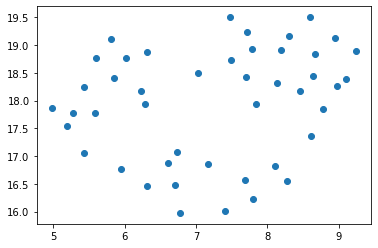

In [1814]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(lcb_def_vectors[lcb_def_vectors.columns.difference(['player_name','team','position','off_val_opp_avg','footedness'])].values)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1])

In [1815]:
clusterable_embedding = umap.UMAP(
    n_neighbors=4,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(lcb_def_vectors[lcb_def_vectors.columns.difference(['player_name','team','position','off_val_opp_avg','footedness'])].values)

In [1816]:
labels = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=5,
).fit_predict(clusterable_embedding)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


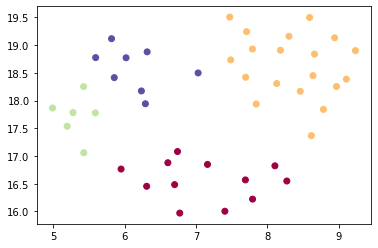

In [1817]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            cmap='Spectral')

In [1818]:
silhouette_avg = silhouette_score(clusterable_embedding, labels) 

In [1819]:
silhouette_avg

0.8094844

In [1820]:
lcb_def_vectors['groups'] = labels

In [1918]:
lcb_def_vectors[lcb_def_vectors['groups']==2]

,player_name,team,position,off_val_opp_avg,att_LC_acc,att_LC_off,att_LC_offcontri,att_LC_pref,att_LF_acc,att_LF_off,att_LF_offcontri,att_LF_pref,att_RC_acc,att_RC_off,att_RC_offcontri,att_RC_pref,att_RF_acc,att_RF_off,att_RF_offcontri,att_RF_pref,foot_right,progaccpass_pm,proginaccpass_pm,footedness,groups
5,AymericLaporte,Manchester City,L_CB,0.269491,1.041661,-0.027579,-1.668174,0.292998,0.889353,-0.026828,2.492839,1.512680,0.791263,-0.318897,-1.763730,-0.892575,0.870798,1.768488,-0.587390,-1.107596,-1.684706,2.097702,-0.616981,left,2
8,CalumChambers,Arsenal,L_CB,NaN,1.890610,-0.936018,-0.068999,-1.408889,1.020183,-0.967782,0.832743,1.047646,0.463517,-1.030212,-2.334646,0.453965,1.549116,0.714517,0.188085,-0.836496,0.593575,1.091511,-1.132377,right,2
32,NicolasHernanOtamendi,Manchester City,L_CB,0.863093,1.150627,-0.166680,-1.301822,-0.253952,1.026350,-0.442107,0.897357,0.644804,1.269204,-0.404177,-1.519653,0.200080,0.626021,-0.011491,0.032849,-0.658345,0.593575,3.059864,-0.445182,right,2
38,ShkodranMustafi,Arsenal,L_CB,NaN,1.064940,-0.668716,-2.967661,-0.628558,0.934284,-0.877685,2.840916,-0.092526,1.634627,-0.581878,-1.627463,2.149299,0.667038,1.216067,-0.003291,-0.939404,0.593575,2.505617,-0.445182,right,2
39,TobyAlderweireld,Tottenham Hotspur,L_CB,NaN,-3.062422,-1.034444,-2.900557,-1.527375,0.934284,0.042285,2.070074,1.839884,1.938115,-0.125096,-1.657276,-1.205779,0.667038,0.395130,0.250676,-0.799981,0.593575,5.225053,0.929210,right,2
41,VirgilvanDijk,Liverpool,L_CB,0.310969,0.011925,-0.301292,-1.032701,-0.601031,0.751034,0.111416,1.439295,0.681783,0.163642,0.063213,-2.462834,-0.439378,0.933866,0.101015,0.299935,-0.461383,0.593575,1.309066,-0.044318,right,2


In [1822]:

from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [1823]:
cluster_report(pd.DataFrame(clusterable_embedding,columns=['c0','c1']),labels,min_samples_leaf=2,pruning_level=0.05)

,class_name,instance_count,rule_list
1,0,12,[1.0] (c1 > -5.469232559204102) and (c0 <= 10.275856018066406)
0,1,19,[1.0] (c1 <= -5.469232559204102)
3,2,6,[1.0] (c1 > -5.469232559204102) and (c0 > 10.275856018066406) and (c0 > 13.587610244750977)
2,3,8,[1.0] (c1 > -5.469232559204102) and (c0 > 10.275856018066406) and (c0 <= 13.587610244750977)


## R_CB Clusters

In [1824]:
rcb_def_vectors = def_vectors_footsep_scaled[def_vectors_footsep_scaled['position']=='R_CB']

In [1825]:
rcb_def_vectors.reset_index(inplace=True)
rcb_def_vectors.drop(['index'],axis=1,inplace=True)

/Users/shreygrover/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [1826]:
rcb_def_vectors = rcb_def_vectors.merge(def_vectors[['player_name','team','position','footedness']],on=['player_name','position','team'])


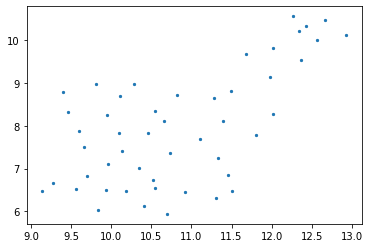

In [1827]:
standard_embedding = umap.UMAP(random_state=22).fit_transform(rcb_def_vectors[rcb_def_vectors.columns.difference(['player_name','team','position','off_val_opp_avg','footedness'])].values)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],s=5)

In [1828]:
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=2,
    random_state=22,
).fit_transform(rcb_def_vectors[rcb_def_vectors.columns.difference(['player_name','team','position','off_val_opp_avg','footedness'])].values)

In [1829]:
labels = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=5,
).fit_predict(clusterable_embedding)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


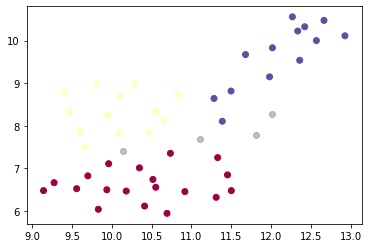

In [1830]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            cmap='Spectral')

In [1831]:
silhouette_avg = silhouette_score(clusterable_embedding, labels) 

In [1832]:
silhouette_avg

0.47802287

In [1833]:
rcb_def_vectors['groups'] = labels

In [1834]:
rcb_def_vectors[rcb_def_vectors['groups']==2]

,player_name,team,position,off_val_opp_avg,att_LC_acc,att_LC_off,att_LC_offcontri,att_LC_pref,att_LF_acc,att_LF_off,att_LF_offcontri,att_LF_pref,att_RC_acc,att_RC_off,att_RC_offcontri,att_RC_pref,att_RF_acc,att_RF_off,att_RF_offcontri,att_RF_pref,foot_right,progaccpass_pm,proginaccpass_pm,footedness,groups
8,DavinsonSanchezMina,Tottenham Hotspur,R_CB,0.149275,0.942105,-0.434310,-0.372184,-0.095971,0.355901,-0.473337,-0.346556,-0.849466,0.451130,-0.605977,-1.362752,0.421933,0.822283,0.142229,-0.720268,0.315955,0.593575,0.541899,-0.517518,right,2
9,DejanLovren,Liverpool,R_CB,0.110605,0.524069,0.173624,-0.749834,-0.455019,0.298195,0.936941,1.427310,-0.936870,0.504292,0.326808,-1.467419,0.998512,0.813904,0.137367,-0.025831,0.587608,0.593575,0.756811,-0.286598,right,2
11,FedericoFernandez,Swansea City,R_CB,NaN,0.089688,-0.925348,0.654798,-1.344260,0.705222,-0.141992,-0.142906,-1.161542,0.611132,0.108489,-0.014698,0.420746,0.688648,0.226914,0.043552,1.272550,0.593575,0.366328,-0.559714,right,2
17,JoelAndreJobMatip,Liverpool,R_CB,0.304695,1.009961,-0.310574,-1.026430,0.483293,0.498184,-0.370210,0.700860,-0.318879,0.731391,-0.211192,-1.291093,0.096865,0.790088,-0.268455,-0.943274,0.126185,0.593575,1.328843,-0.132820,right,2
18,JohnStones,Manchester City,R_CB,0.285190,1.630081,-0.691481,-1.104027,-0.031342,1.334704,0.296349,0.746464,-0.775509,1.605208,-0.280866,-1.661845,-0.422769,1.320217,0.206974,-0.307540,0.462570,0.593575,1.442946,-1.925296,right,2
19,JoseMigueldaRochaFonte,West Ham United,R_CB,NaN,1.890610,-0.059579,-0.071578,-1.491470,-0.133500,-0.786164,-0.373094,-1.092067,-0.929531,-0.799978,-0.680794,-0.164138,0.332289,0.021414,-1.181271,1.442955,0.593575,0.003736,0.585612,right,2
22,LaurentKoscielny,Arsenal,R_CB,NaN,0.961917,-0.728248,-1.535427,-0.492120,0.133446,0.101727,1.377369,-0.867395,0.325193,-0.082635,-1.467710,-0.491579,1.203341,-0.052352,1.718885,0.925653,0.593575,2.266307,-0.032864,right,2
30,NicolasHernanOtamendi,Manchester City,R_CB,0.228013,1.016400,-0.883026,-1.194834,-1.027101,1.177443,0.586488,1.394826,-0.531786,0.733972,-0.420774,-1.706115,-0.164138,1.052947,0.066654,-0.451824,0.930632,0.593575,2.369646,-0.702880,right,2
37,ShkodranMustafi,Arsenal,R_CB,0.954400,0.990149,-0.680011,0.186567,-1.255695,0.076180,0.073093,0.790487,-1.135209,0.106868,-0.033313,-0.685892,0.376850,0.714670,0.304444,0.208616,1.275869,0.593575,0.438846,-0.032864,right,2
41,TobyAlderweireld,Tottenham Hotspur,R_CB,0.574094,0.475529,-0.395166,-1.132848,-0.062460,1.334704,1.004500,-0.154779,-0.749736,0.131642,-0.421368,0.318940,-0.164138,0.538254,0.100779,-0.335893,0.684982,0.593575,2.179285,0.929210,right,2


In [1835]:

from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [1836]:
cluster_report(pd.DataFrame(clusterable_embedding,columns=['c0','c1']),labels,min_samples_leaf=2,pruning_level=0.05)

,class_name,instance_count,rule_list
3,-1,4,[1.0] (c1 <= 5.273153066635132) and (c0 > 12.060020446777344) and (c1 > 4.171523809432983)
0,0,19,[1.0] (c1 > 5.273153066635132)
2,1,13,[1.0] (c1 <= 5.273153066635132) and (c0 > 12.060020446777344) and (c1 <= 4.171523809432983)
1,2,13,[1.0] (c1 <= 5.273153066635132) and (c0 <= 12.060020446777344)


## LB Clusters

In [1837]:
lb_def_vectors = def_vectors_footsep_scaled[def_vectors_footsep_scaled['position']=='LB']

In [1838]:
lb_def_vectors.reset_index(inplace=True)
lb_def_vectors.drop(['index'],axis=1,inplace=True)

/Users/shreygrover/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [1839]:
lb_def_vectors.head()

,player_name,team,position,off_val_opp_avg,att_LC_acc,att_LC_off,att_LC_offcontri,att_LC_pref,att_LF_acc,att_LF_off,att_LF_offcontri,att_LF_pref,att_RC_acc,att_RC_off,att_RC_offcontri,att_RC_pref,att_RF_acc,att_RF_off,att_RF_offcontri,att_RF_pref,foot_right,progaccpass_pm,proginaccpass_pm
0,AaronCresswell,West Ham United,LB,0.026267,-1.411576,-0.876515,3.151266,1.433573,-0.537443,-0.215686,-0.084316,1.086306,0.217837,1.285909,0.287237,-1.350517,-1.658563,-0.865992,-0.022101,-0.851988,-1.684706,-0.617849,2.107259
1,AdamSmith,AFC Bournemouth,LB,0.485561,-0.585906,-0.708734,-0.792201,1.078116,0.934284,0.894947,-0.439047,0.262132,-0.274040,0.746815,-1.933281,0.102797,0.997817,0.663907,0.039847,-0.331919,0.593575,0.003736,-0.216117
2,AlbertoMorenoPerez,Liverpool,LB,0.079501,0.347741,-0.332831,-0.364833,1.747141,-0.192528,0.388443,0.797534,0.843704,-0.375719,0.618884,-1.019146,-0.301758,-0.054503,0.235446,-1.159053,-1.202758,-1.684706,-0.042882,0.634697
3,AllanRomeoNyom,West Bromwich Albion,LB,NaN,0.033223,0.910602,1.583234,1.145138,0.076180,-0.486981,0.256111,-0.051065,0.217837,-1.343912,1.215493,-0.915116,-1.758679,-0.968567,-0.131451,-0.001620,0.593575,-0.793965,0.471079
4,AndrewRobertson,Liverpool,LB,0.133556,0.168936,-0.175572,-1.059965,2.607659,0.720199,0.738366,1.817680,0.935590,-0.642560,1.756924,-1.801593,-0.932912,-1.932890,-2.720588,-0.345906,-1.273022,-1.684706,1.039712,1.518235


In [1840]:
lb_def_vectors = lb_def_vectors.merge(def_vectors[['player_name','team','position','footedness']],on=['player_name','position','team'])


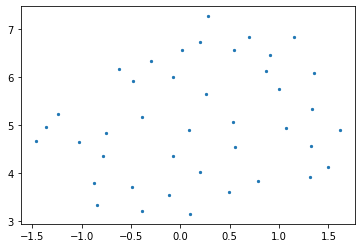

In [1841]:
standard_embedding = umap.UMAP(random_state=22).fit_transform(lb_def_vectors[lb_def_vectors.columns.difference(['player_name','team','position','off_val_opp_avg','footedness'])].values)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],s=5)

In [1842]:
clusterable_embedding = umap.UMAP(
    n_neighbors=6,
    min_dist=0.0,
    n_components=2,
    random_state=22,
).fit_transform(lb_def_vectors[lb_def_vectors.columns.difference(['player_name','team','position','off_val_opp_avg','footedness'])].values)

In [1843]:
labels = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=6,
).fit_predict(clusterable_embedding)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


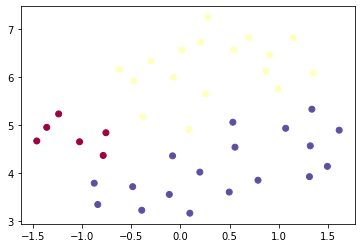

In [1844]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            cmap='Spectral')

In [1845]:
silhouette_avg = silhouette_score(clusterable_embedding, labels) 

In [1846]:
silhouette_avg

0.4784041

In [1847]:
lb_def_vectors['groups'] = labels

In [1848]:
lb_def_vectors[lb_def_vectors['groups']==0]

,player_name,team,position,off_val_opp_avg,att_LC_acc,att_LC_off,att_LC_offcontri,att_LC_pref,att_LF_acc,att_LF_off,att_LF_offcontri,att_LF_pref,att_RC_acc,att_RC_off,att_RC_offcontri,att_RC_pref,att_RF_acc,att_RF_off,att_RF_offcontri,att_RF_pref,foot_right,progaccpass_pm,proginaccpass_pm,footedness,groups
6,AshleyYoung,Manchester United,LB,0.082149,-0.417007,0.211872,-0.175021,0.818404,0.323304,1.075568,0.196670,1.698693,-0.251330,2.545275,-0.326689,-1.036126,-0.308101,-1.060873,-0.534334,-1.230974,0.593575,0.521724,1.256446,right,0
10,ChancelMbembaMangulu,Newcastle United,LB,NaN,-1.081209,-0.541297,-0.746283,1.923075,0.298195,1.017208,0.889957,0.761343,1.938115,2.839892,-0.426610,-0.523611,-2.861278,-1.734180,0.559525,-1.276342,0.593575,-0.822972,-0.032864,right,0
12,CharlieTaylor,Burnley,LB,0.153390,0.314555,-0.129031,-0.573264,0.374382,-0.577089,0.231994,0.580817,1.451609,0.561583,3.835122,0.285951,-0.431074,-2.126065,-0.760352,1.395449,-1.208844,-1.684706,-0.583662,0.310734,left,0
24,JoseHolebas,Watford,LB,0.065835,-0.440287,-0.165419,-0.136638,0.450979,-0.461236,0.300500,1.002202,1.709339,-0.530559,3.149127,0.538289,-0.975621,-1.538160,-0.987474,-0.157851,-1.055036,-1.684706,-0.477174,1.290892,left,0
35,RhuendlyMartina,Everton,LB,0.119641,-0.162917,-0.390122,0.198782,1.323465,-0.011480,0.572126,0.130069,1.457212,1.468948,4.626844,0.679955,-1.216456,-1.391294,-0.586184,-0.026321,-1.292387,0.593575,-0.540151,-0.052499,right,0
38,SeadKolasinac,Arsenal,LB,0.394149,-1.486367,-0.607844,0.531773,1.714827,0.747510,0.939415,0.652091,1.068377,-0.642560,5.350176,-0.276434,-1.095445,0.446518,-0.574102,-0.282558,-1.202758,-1.684706,-0.784900,-0.359282,left,0


In [1849]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [1850]:
cluster_report(pd.DataFrame(clusterable_embedding,columns=['c0','c1']),labels,min_samples_leaf=2,pruning_level=0.04)

,class_name,instance_count,rule_list
2,0,6,[1.0] (c0 > 9.047782897949219) and (c1 <= 7.582035064697266)
1,1,17,[1.0] (c0 <= 9.047782897949219)
0,2,18,[0.9473684210526315] (c0 > 9.047782897949219) and (c1 > 7.582035064697266)


## RB Clusters

In [1851]:
rb_def_vectors = def_vectors_footsep_scaled[def_vectors_footsep_scaled['position']=='RB']

In [1852]:
rb_def_vectors.reset_index(inplace=True)
rb_def_vectors.drop(['index'],axis=1,inplace=True)

/Users/shreygrover/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [1853]:
rb_def_vectors.head()

,player_name,team,position,off_val_opp_avg,att_LC_acc,att_LC_off,att_LC_offcontri,att_LC_pref,att_LF_acc,att_LF_off,att_LF_offcontri,att_LF_pref,att_RC_acc,att_RC_off,att_RC_offcontri,att_RC_pref,att_RF_acc,att_RF_off,att_RF_offcontri,att_RF_pref,foot_right,progaccpass_pm,proginaccpass_pm
0,AaronWanBissaka,Crystal Palace,RB,0.232525,-0.585906,1.313847,-0.516171,-1.345457,-0.867822,-1.484806,-0.435248,-1.213649,0.389710,2.782187,0.914782,-0.130920,0.156314,0.164838,-0.502904,2.035502,0.593575,-0.742166,-0.543353
1,AdamSmith,AFC Bournemouth,RB,NaN,0.475529,0.120342,-0.208347,-1.367000,0.600382,-0.053833,-0.671224,-1.086465,0.045448,-0.072939,0.532911,1.215620,0.030618,0.138355,-0.097135,1.655962,0.593575,-0.409618,-0.101584
2,AdrianMariappa,Watford,RB,0.470534,-3.062422,-0.812078,0.146929,-1.236546,-0.133500,-0.906594,-0.461741,-0.757019,-2.190965,-1.273120,0.204553,0.139574,-0.856754,-0.181543,1.231468,0.812787,0.593575,-1.084038,0.700144
3,AllanRomeoNyom,West Bromwich Albion,RB,0.097606,-0.090603,1.144489,0.643434,-0.064853,-1.969085,-2.127069,0.172414,-1.246705,-0.355589,0.033022,0.296771,0.844283,0.381685,0.089314,-0.147225,1.102697,0.593575,-0.561906,-0.353556
4,AshleyYoung,Manchester United,RB,NaN,0.239765,1.635290,-0.318317,0.605369,1.334704,0.970844,-2.670672,-1.260152,0.061448,4.997267,2.005450,1.204942,0.323909,0.442451,0.261870,1.025240,0.593575,0.982733,1.616405


In [1854]:
rb_def_vectors = rb_def_vectors.merge(def_vectors[['player_name','team','position','footedness']],on=['player_name','position','team'])


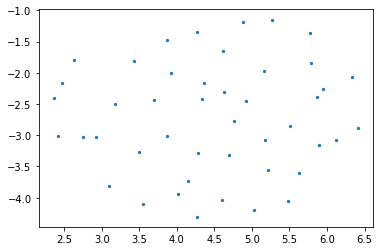

In [1855]:
standard_embedding = umap.UMAP(random_state=22,learning_rate=1).fit_transform(rb_def_vectors[rb_def_vectors.columns.difference(['player_name','team','position','off_val_opp_avg','footedness'])].values)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],s=5)

In [1856]:
clusterable_embedding = umap.UMAP(
    n_neighbors=6,
    min_dist=0.0,
    n_components=2,
    random_state=22,
).fit_transform(rb_def_vectors[rb_def_vectors.columns.difference(['player_name','team','position','off_val_opp_avg','footedness'])].values)

In [1857]:
labels = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=6,
).fit_predict(clusterable_embedding)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


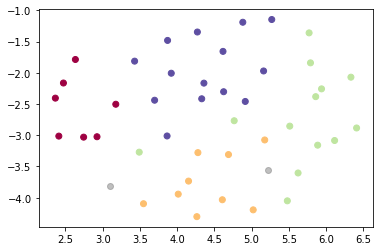

In [1858]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            cmap='Spectral')

In [1859]:
silhouette_avg = silhouette_score(clusterable_embedding, labels) 

In [1860]:
silhouette_avg

0.42412284

In [1861]:
rb_def_vectors['groups'] = labels

In [1862]:
rb_def_vectors[rb_def_vectors['groups']==-1]

,player_name,team,position,off_val_opp_avg,att_LC_acc,att_LC_off,att_LC_offcontri,att_LC_pref,att_LF_acc,att_LF_off,att_LF_offcontri,att_LF_pref,att_RC_acc,att_RC_off,att_RC_offcontri,att_RC_pref,att_RF_acc,att_RF_off,att_RF_offcontri,att_RF_pref,foot_right,progaccpass_pm,proginaccpass_pm,footedness,groups
16,HectorBellerinMoruno,Arsenal,RB,0.380682,-0.420970,0.409660,-0.833172,-0.865530,1.334704,-0.216001,1.090899,-1.363244,0.158481,0.608008,-0.646091,2.808926,0.502530,0.535492,0.714617,0.820532,0.593575,-0.446913,-0.445182,right,-1
18,JavierManquilloGaitan,Newcastle United,RB,0.444594,0.652352,3.413708,0.484296,0.069191,-3.070348,-0.819721,1.187021,-1.403584,-1.346569,0.246330,-0.923590,0.892925,-0.839994,-0.386459,-0.229009,1.559694,0.593575,-1.040527,0.516892,right,-1


In [1863]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [1864]:
cluster_report(pd.DataFrame(clusterable_embedding,columns=['c0','c1']),labels,min_samples_leaf=4,pruning_level=0.04)

,class_name,instance_count,rule_list
4,-1,2,NaN
3,0,7,[0.8333333333333334] (c1 > 5.131679058074951) and (c0 <= 5.120296239852905) and (c1 > 6.7171642780303955)
2,1,9,[1.0] (c1 > 5.131679058074951) and (c0 <= 5.120296239852905) and (c1 <= 6.7171642780303955)
1,2,13,[0.8666666666666667] (c1 <= 5.131679058074951)
0,3,14,[0.875] (c1 > 5.131679058074951) and (c0 > 5.120296239852905)


## Merging the groups to lineups

In [1865]:
four_clusters = ['rlll', 'rrll', 'rrlr', 'rrrl', 'rrrr']
df_fourclusters = pd.concat(
    (pd.read_pickle(f'../data/clusters/clusters_vaep/cluster_{i}.pkl')
     for i in four_clusters),
    axis=0)

In [1866]:
df_4clusters_team=pd.DataFrame(df_fourclusters.groupby(['team','RB','R_CB','L_CB','LB'])['wyId'].count())

In [1867]:
df_4clusters_team.reset_index(inplace=True)

In [1868]:
df_4clusters_team[df_4clusters_team['team'].str.contains("Chelsea")]

,team,RB,R_CB,L_CB,LB,wyId


In [1869]:
 player_map = {  'RamiroFunesMori': 'JoseRamiroFunesMori',
                'KurtZouma': 'KurtHappyZouma',
                'Danilo': 'DaniloLuizdaSilva',
                'CesarAzpilicueta': 'CesarAzpilicuetaTanco',
                'EzequielSchelotto': 'MatiasEzequielSchelotto',
                'GaetanBong': 'GaetanBongSongo',
                'HectorBellerin': 'HectorBellerinMoruno',
                'AhmedHegazi': 'AhmedHegazy',
                'JamaalLascelles': 'JamalLascelles',
                'AngelRangel': 'AngelRangelZaragoza',
                'Zanka': 'MathiasJattahNjieJorgensen',
                'EricBailly': 'EricBertrandBailly',
                'MarcosRojo': 'FaustinoMarcosAlbertoRojo',
                'AngeloOgbonna': 'AngeloObinzeOgbonna',
                'DavinsonSanchez': 'DavinsonSanchezMina',
                'JavierManquillo': 'JavierManquilloGaitan',
                'TommySmith': 'TomSmith',
                'Bruno': 'BrunoSaltorGrau',
                'JosephGomez': 'JoeGomez',
                'AlbertoMoreno':'AlbertoMorenoPerez',
                'LuisAntonioValencia':'LuisAntonioValenciaMosquera',
                'NicolasOtamendi':'NicolasHernanOtamendi',
                'NachoMonreal':'IgnacioMonrealEraso',
                'CedricSoares':'CedricRicardoAlvesSoares',
                'JoelMatip':'JoelAndreJobMatip',
                'MiguelBritos':'MiguelAngelBritosCabrera',
                'VictorLindelof':'VictorNilssonLindelof',
                'JamesCollins':'JamesMichaelCollins',
                'CucoMartina':'RhuendlyMartina',
                'DavidLuiz':'DavidLuizMoreiraMarinho',
                'ChancelMbemba':'ChancelMbembaMangulu',
                'PabloZabaleta':'PabloJavierZabaletaGirod',
                'KikoFemenia':'FranciscoFemeniaFar',
                'JoseFonte':'JoseMigueldaRochaFonte',
                'JesusGamez':'JesusGamezDuarte'}

In [1870]:
positions = ['RB','R_CB','L_CB','LB']
for index,row in df_4clusters_team.iterrows():
    for pos in positions:
        try:
            replace = player_map[row[pos]]
        except:
            continue
        df_4clusters_team[pos][index] = replace 

/Users/shreygrover/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1871]:
df_4clusters_team[df_4clusters_team['team'].str.contains("Manchester City")]

,team,RB,R_CB,L_CB,LB,wyId
101,Manchester City,DaniloLuizdaSilva,JohnStones,AymericLaporte,FabianDelph,1
102,Manchester City,DaniloLuizdaSilva,NicolasHernanOtamendi,EliaquimMangala,FabianDelph,1
103,Manchester City,DaniloLuizdaSilva,VincentKompany,AymericLaporte,FabianDelph,1
104,Manchester City,DaniloLuizdaSilva,VincentKompany,AymericLaporte,OleksandrZinchenko,1
105,Manchester City,DaniloLuizdaSilva,VincentKompany,NicolasHernanOtamendi,BenjaminMendy,1
106,Manchester City,DaniloLuizdaSilva,VincentKompany,NicolasHernanOtamendi,FabianDelph,1
107,Manchester City,KyleWalker,JohnStones,NicolasHernanOtamendi,BenjaminMendy,2
108,Manchester City,KyleWalker,JohnStones,NicolasHernanOtamendi,FabianDelph,8
109,Manchester City,KyleWalker,JohnStones,NicolasHernanOtamendi,OleksandrZinchenko,1
110,Manchester City,KyleWalker,JohnStones,VincentKompany,FabianDelph,1


In [1872]:
df_4clusters_team.rename(columns = {'wyId':'matches_played'},inplace=True)

In [1873]:
df_4clusters_team = df_4clusters_team.merge(rb_def_vectors[['player_name','team','groups']], how = 'left',
                                            left_on=['RB','team'], right_on = ['player_name','team'])

In [1874]:
df_4clusters_team.drop(['player_name'],inplace=True,axis=1)

In [1875]:
df_4clusters_team.rename(columns = {'groups':'RB_groups'},inplace=True)

In [1876]:
df_4clusters_team = df_4clusters_team.merge(rcb_def_vectors[['player_name','team','groups']], how = 'left',
                                            left_on=['R_CB','team'], right_on = ['player_name','team'])

In [1877]:
df_4clusters_team.drop(['player_name'],inplace=True,axis=1)

In [1878]:
df_4clusters_team.rename(columns = {'groups':'R_CB_groups'},inplace=True)

In [1879]:
df_4clusters_team = df_4clusters_team.merge(lcb_def_vectors[['player_name','team','groups']], how = 'left',
                                            left_on=['L_CB','team'], right_on = ['player_name','team'])

In [1880]:
df_4clusters_team.drop(['player_name'],inplace=True,axis=1)

In [1881]:
df_4clusters_team.rename(columns = {'groups':'L_CB_groups'},inplace=True)

In [1882]:
df_4clusters_team[df_4clusters_team['team'].str.contains("Tottenham Hotspur")]

,team,RB,R_CB,L_CB,LB,matches_played,RB_groups,R_CB_groups,L_CB_groups
175,Tottenham Hotspur,KieranTrippier,DavinsonSanchezMina,JanVertonghen,BenDavies,9,3.0,2.0,0.0
176,Tottenham Hotspur,KieranTrippier,DavinsonSanchezMina,TobyAlderweireld,JanVertonghen,1,3.0,2.0,2.0
177,Tottenham Hotspur,KieranTrippier,EricDier,JanVertonghen,BenDavies,1,3.0,NaN,0.0
178,Tottenham Hotspur,KieranTrippier,EricDier,JanVertonghen,DannyRose,1,3.0,NaN,0.0
179,Tottenham Hotspur,KieranTrippier,TobyAlderweireld,JanVertonghen,BenDavies,2,3.0,2.0,0.0
180,Tottenham Hotspur,KyleWalkerPeters,TobyAlderweireld,EricDier,DannyRose,1,0.0,2.0,NaN
181,Tottenham Hotspur,KyleWalkerPeters,TobyAlderweireld,JanVertonghen,BenDavies,1,0.0,2.0,0.0
182,Tottenham Hotspur,SergeAurier,DavinsonSanchezMina,EricDier,BenDavies,1,1.0,2.0,NaN
183,Tottenham Hotspur,SergeAurier,DavinsonSanchezMina,JanVertonghen,BenDavies,5,1.0,2.0,0.0
184,Tottenham Hotspur,SergeAurier,DavinsonSanchezMina,JanVertonghen,DannyRose,3,1.0,2.0,0.0


In [1883]:
df_4clusters_team = df_4clusters_team.merge(lb_def_vectors[['player_name','team','groups']], how ='left',
                                            left_on=['LB','team'], right_on = ['player_name','team'])

In [1884]:
df_4clusters_team.drop(['player_name'],inplace=True,axis=1)

In [1885]:
df_4clusters_team.rename(columns = {'groups':'LB_groups'},inplace=True)

In [1926]:
df_4clusters_team[df_4clusters_team['team'].str.contains("West Bromwich Albion")]

,team,RB,R_CB,L_CB,LB,matches_played,RB_groups,R_CB_groups,L_CB_groups,LB_groups
202,West Bromwich Albion,AllanRomeoNyom,AhmedHegazy,JonnyEvans,KieranGibbs,5,0.0,0.0,1.0,1.0
203,West Bromwich Albion,AllanRomeoNyom,CraigDawson,AhmedHegazy,ChrisBrunt,3,0.0,1.0,1.0,NaN
204,West Bromwich Albion,AllanRomeoNyom,CraigDawson,AhmedHegazy,KieranGibbs,7,0.0,1.0,1.0,1.0
205,West Bromwich Albion,CraigDawson,AhmedHegazy,JonnyEvans,KieranGibbs,7,2.0,0.0,1.0,1.0
206,West Bromwich Albion,CraigDawson,GarethMcAuley,AhmedHegazy,AllanRomeoNyom,2,2.0,NaN,1.0,1.0
207,West Bromwich Albion,CraigDawson,JonnyEvans,AhmedHegazy,AllanRomeoNyom,1,2.0,NaN,1.0,1.0
208,West Bromwich Albion,CraigDawson,JonnyEvans,AhmedHegazy,KieranGibbs,3,2.0,NaN,1.0,1.0


In [1887]:
top_five = ['Manchester City','Manchester United','Tottenham Hotspur','Liverpool','Chelsea']

In [1888]:
bottom_five = ['Huddersfield Town','Southampton','Swansea City','Stoke City','West Bromwich Albion']

In [1889]:
df_4clusters_team[df_4clusters_team['team'].str.contains("Manchester United")].dropna()

,team,RB,R_CB,L_CB,LB,matches_played,RB_groups,R_CB_groups,L_CB_groups,LB_groups
119,Manchester United,AshleyYoung,PhilJones,FaustinoMarcosAlbertoRojo,LukeShaw,1,3.0,-1.0,0.0,2.0
120,Manchester United,AshleyYoung,VictorNilssonLindelof,PhilJones,LukeShaw,1,3.0,1.0,3.0,2.0
121,Manchester United,LuisAntonioValenciaMosquera,ChrisSmalling,FaustinoMarcosAlbertoRojo,AshleyYoung,1,1.0,1.0,0.0,0.0
122,Manchester United,LuisAntonioValenciaMosquera,ChrisSmalling,FaustinoMarcosAlbertoRojo,LukeShaw,1,1.0,1.0,0.0,2.0
123,Manchester United,LuisAntonioValenciaMosquera,ChrisSmalling,PhilJones,AshleyYoung,6,1.0,1.0,3.0,0.0
124,Manchester United,LuisAntonioValenciaMosquera,ChrisSmalling,PhilJones,LukeShaw,2,1.0,1.0,3.0,2.0
126,Manchester United,LuisAntonioValenciaMosquera,ChrisSmalling,VictorNilssonLindelof,AshleyYoung,5,1.0,1.0,3.0,0.0
127,Manchester United,LuisAntonioValenciaMosquera,EricBertrandBailly,ChrisSmalling,AshleyYoung,2,1.0,-1.0,3.0,0.0
128,Manchester United,LuisAntonioValenciaMosquera,EricBertrandBailly,PhilJones,AshleyYoung,2,1.0,-1.0,3.0,0.0
129,Manchester United,LuisAntonioValenciaMosquera,EricBertrandBailly,PhilJones,DaleyBlind,3,1.0,-1.0,3.0,2.0


In [1890]:
x= pd.DataFrame(df_4clusters_team[df_4clusters_team['team'].str.contains("Manchester United")].groupby(['RB_groups','R_CB_groups','L_CB_groups','LB_groups'])['matches_played'].sum())

In [1891]:
x.reset_index(inplace=True)

In [1892]:
x

,RB_groups,R_CB_groups,L_CB_groups,LB_groups,matches_played
0,1.0,-1.0,0.0,0.0,1
1,1.0,-1.0,3.0,0.0,4
2,1.0,-1.0,3.0,2.0,3
3,1.0,1.0,0.0,0.0,2
4,1.0,1.0,0.0,2.0,1
5,1.0,1.0,3.0,0.0,13
6,1.0,1.0,3.0,2.0,3
7,3.0,-1.0,0.0,2.0,1
8,3.0,1.0,3.0,2.0,1


In [1893]:
def_vectors_ind_footsep_lcb = def_vectors_ind_footsep.merge(lcb_def_vectors[['player_name','position','team','groups']],on=['player_name','team','position'])

In [1896]:
len(def_vectors_ind_footsep_lcb)

45

In [1897]:
def_vectors_ind_footsep_rcb = def_vectors_ind_footsep.merge(rcb_def_vectors[['player_name','position','team','groups']],on=['player_name','team','position'])

In [1898]:
len(def_vectors_ind_footsep_rcb)

49

In [1899]:
def_vectors_ind_footsep_lb = def_vectors_ind_footsep.merge(lb_def_vectors[['player_name','position','team','groups']],on=['player_name','team','position'])

In [1900]:
len(def_vectors_ind_footsep_lb)

41

In [1901]:
def_vectors_ind_footsep_rb = def_vectors_ind_footsep.merge(rb_def_vectors[['player_name','position','team','groups']],on=['player_name','team','position'])

In [1902]:
len(def_vectors_ind_footsep_rb)

45

In [1933]:
def_vectors_ind_footsep_lb[def_vectors_ind_footsep_lb['groups']==2]

,player_name,team,position,progaccpass_pm,proginaccpass_pm,off_val_opp_avg,foot_left,foot_right,att_LF_pref,att_LC_pref,att_RC_pref,att_RF_pref,att_LF_acc,att_LC_acc,att_RC_acc,att_RF_acc,att_LF_off,att_LC_off,att_RC_off,att_RF_off,att_LF_offcontri,att_LC_offcontri,att_RC_offcontri,att_RF_offcontri,groups
1,AdamSmith,AFC Bournemouth,LB,9.000000,3.333333,0.485561,0,1,29.73,27.03,18.92,21.62,90.91,50.00,57.14,87.50,5.263003,3.967432,17.062913,5.561234,0.933989,0.678025,0.591580,0.944362,2
2,AlbertoMorenoPerez,Liverpool,LB,8.785714,4.571429,0.079501,1,0,40.11,32.62,15.51,5.88,65.33,68.85,55.17,63.64,3.708340,7.239163,15.858645,3.667682,0.987605,0.711085,0.659939,0.729934,2
4,AndrewRobertson,Liverpool,LB,13.761905,5.857143,0.133556,1,0,41.75,39.81,10.19,4.61,86.05,65.24,50.00,21.05,4.782394,8.607883,26.571463,-9.396287,1.031836,0.657311,0.601428,0.875368,2
8,BenDavies,Tottenham Hotspur,LB,10.850000,4.800000,0.224526,1,0,41.85,37.38,11.82,5.75,76.34,70.09,62.16,27.78,3.787436,12.014431,24.460906,-8.614437,0.954967,0.746272,0.659912,0.837414,2
9,BenjaminMendy,Manchester City,LB,6.000000,5.000000,NaN,1,0,30.30,30.30,9.09,30.30,90.00,40.00,66.67,30.00,9.182899,-0.248685,25.491797,-2.065142,0.944136,0.614009,0.548779,0.592847,2
15,DaleyBlind,Manchester United,LB,14.000000,5.000000,0.456347,1,0,52.63,26.32,8.77,5.26,80.00,73.33,80.00,33.33,5.209470,13.538396,24.376836,-5.759718,0.985865,0.734221,0.638260,0.710975,2
16,DaniloLuizdaSilva,Manchester City,LB,14.600000,3.000000,4.506438,0,1,52.27,30.68,7.95,3.41,95.65,59.26,85.71,66.67,5.473496,3.981862,2.801207,11.886917,1.011546,0.699405,0.608880,1.193543,2
17,DannyRose,Tottenham Hotspur,LB,9.166667,3.666667,0.031596,1,0,46.75,23.38,16.88,9.09,77.78,77.78,61.54,42.86,6.344409,15.048283,26.238283,-4.261036,0.957544,0.662465,0.726894,0.658038,2
20,IgnacioMonrealEraso,Arsenal,LB,6.285714,2.428571,NaN,1,0,47.54,37.70,1.64,6.56,86.21,56.52,100.00,50.00,3.101864,4.718369,16.989667,-3.790065,1.032294,0.640807,0.632973,0.962984,2
21,JavierManquilloGaitan,Newcastle United,LB,5.166667,2.916667,0.090719,0,1,49.48,29.90,10.31,4.12,77.08,55.17,50.00,75.00,3.349535,1.884946,14.791907,7.865531,0.950646,0.753134,0.774604,0.868393,2


In [1927]:
def_vectors_ind_footsep_lb[def_vectors_ind_footsep_lb['groups']==0].describe()

,progaccpass_pm,proginaccpass_pm,off_val_opp_avg,foot_left,foot_right,att_LF_pref,att_LC_pref,att_RC_pref,att_RF_pref,att_LF_acc,att_LC_acc,att_RC_acc,att_RF_acc,att_LF_off,att_LC_off,att_RC_off,att_RF_off,att_LF_offcontri,att_LC_offcontri,att_RC_offcontri,att_RF_offcontri,groups
count,6.000000,6.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0
mean,6.924238,4.233156,0.163033,0.500000,0.500000,49.285000,27.220000,10.638333,5.730000,70.908333,50.815000,70.665000,35.481667,4.632307,7.783346,45.092159,-1.573639,0.977969,0.727696,0.742063,0.965670,0.0
std,2.272587,1.029748,0.133585,0.547723,0.547723,6.668618,5.456607,2.722678,1.527049,11.491105,13.040266,21.061002,27.244588,1.142962,2.654765,10.289013,1.914444,0.015376,0.036645,0.036042,0.126460,0.0
min,5.200000,3.125000,0.065835,0.000000,0.000000,38.640000,21.150000,7.800000,4.260000,56.600000,31.820000,50.000000,0.000000,3.228134,4.845547,33.992527,-5.036931,0.958665,0.681577,0.704248,0.841667,0.0
25%,5.606250,3.578571,0.082149,0.000000,0.000000,45.830000,22.557500,8.945000,4.755000,61.782500,43.235000,53.522500,20.002500,3.646838,5.753689,37.493616,-1.980208,0.965716,0.702663,0.712660,0.892275,0.0
50%,6.400000,3.850000,0.119641,0.500000,0.500000,51.010000,26.970000,9.575000,5.570000,72.955000,53.175000,65.455000,31.665000,4.835815,7.718383,42.905602,-1.235047,0.979753,0.727253,0.736506,0.920765,0.0
75%,6.717105,5.132143,0.153390,1.000000,1.000000,54.292500,31.532500,12.687500,5.852500,76.897500,57.257500,86.515000,51.750000,5.578577,8.933783,51.723968,-0.155883,0.989034,0.748199,0.771686,1.011113,0.0
max,11.380952,5.526316,0.394149,1.000000,1.000000,55.560000,34.090000,14.420000,8.550000,86.670000,68.180000,100.000000,75.000000,5.817403,11.980057,60.396178,0.089947,0.996479,0.780445,0.786997,1.186816,0.0


In [1928]:
def_vectors_ind_footsep_lb[def_vectors_ind_footsep_lb['groups']==1].describe()

,progaccpass_pm,proginaccpass_pm,off_val_opp_avg,foot_left,foot_right,att_LF_pref,att_LC_pref,att_RC_pref,att_RF_pref,att_LF_acc,att_LC_acc,att_RC_acc,att_RF_acc,att_LF_off,att_LC_off,att_RC_off,att_RF_off,att_LF_offcontri,att_LC_offcontri,att_RC_offcontri,att_RF_offcontri,groups
count,17.000000,17.000000,11.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0
mean,6.570330,4.623855,0.109955,0.941176,0.058824,45.157647,29.707647,11.760588,7.633529,71.121765,49.914706,47.002941,28.361176,3.346177,7.330520,12.116652,-3.577822,0.941666,0.785282,0.774634,0.937619,1.0
std,1.437507,1.129530,0.089219,0.242536,0.242536,7.910011,4.831772,4.884640,6.160845,10.333050,12.013570,18.418380,17.203584,1.113983,4.988786,10.754467,4.439592,0.016351,0.071395,0.031396,0.066374,0.0
min,3.000000,3.000000,0.008191,0.000000,0.000000,24.140000,21.620000,4.130000,0.000000,57.500000,14.290000,0.000000,0.000000,1.021313,-6.551004,-4.166052,-17.149648,0.909768,0.675194,0.713176,0.825816,1.0
25%,5.875000,3.760000,0.057756,1.000000,0.000000,40.940000,27.800000,9.090000,4.130000,65.000000,46.880000,36.840000,25.000000,2.989075,6.225631,4.421012,-5.482062,0.933132,0.737827,0.748208,0.900104,1.0
50%,6.166667,4.476190,0.082141,1.000000,0.000000,45.960000,29.050000,10.340000,5.930000,69.740000,52.240000,45.450000,28.570000,3.343174,7.321075,13.292644,-2.391892,0.941911,0.785560,0.778893,0.933282,1.0
75%,7.666667,4.875000,0.130744,1.000000,0.000000,49.260000,33.090000,12.840000,8.710000,76.870000,58.820000,59.460000,40.000000,3.948258,9.623277,20.151310,-1.200041,0.955318,0.815742,0.793434,0.984615,1.0
max,8.500000,6.714286,0.287644,1.000000,1.000000,59.260000,41.670000,24.000000,27.590000,100.000000,62.500000,83.330000,50.000000,5.692853,18.061546,33.064957,2.786618,0.966184,0.983086,0.832054,1.056738,1.0


In [1929]:
def_vectors_ind_footsep_lb[def_vectors_ind_footsep_lb['groups']==2].describe()

,progaccpass_pm,proginaccpass_pm,off_val_opp_avg,foot_left,foot_right,att_LF_pref,att_LC_pref,att_RC_pref,att_RF_pref,att_LF_acc,att_LC_acc,att_RC_acc,att_RF_acc,att_LF_off,att_LC_off,att_RC_off,att_RF_off,att_LF_offcontri,att_LC_offcontri,att_RC_offcontri,att_RF_offcontri,groups
count,18.000000,18.000000,14.000000,18.000000,18.000000,18.000000,18.000000,18.00000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,9.641428,4.245401,0.493462,0.777778,0.222222,46.088333,30.697222,11.12500,7.048889,80.801667,59.822222,58.328889,50.416111,5.336663,7.754441,17.138607,3.385697,0.977603,0.717999,0.687082,0.847592,2.0
std,3.461889,1.149247,1.165898,0.427793,0.427793,7.871858,4.780061,6.77243,7.267240,8.161222,11.417448,20.404322,23.979722,1.724768,5.236128,9.543176,12.835266,0.065328,0.056606,0.083292,0.150233,0.0
min,5.166667,2.428571,0.016965,0.000000,0.000000,29.730000,23.380000,1.64000,0.000000,65.330000,40.000000,0.000000,0.000000,3.101864,-0.248685,-10.690321,-9.396287,0.856085,0.614009,0.548779,0.592847,2.0
25%,7.062500,3.488095,0.082306,1.000000,0.000000,42.102500,27.337500,7.42500,4.030000,75.095000,50.000000,50.000000,35.712500,4.567464,3.971039,14.876070,-3.358834,0.951726,0.681601,0.615677,0.734905,2.0
50%,8.937500,3.897321,0.134592,1.000000,0.000000,46.610000,30.835000,9.54500,4.970000,79.950000,62.250000,58.570000,50.000000,4.823952,7.130397,17.227690,0.830312,0.962158,0.713024,0.659926,0.871881,2.0
75%,10.618269,4.950000,0.365823,1.000000,0.000000,51.882500,32.435000,13.29750,5.847500,86.170000,68.452500,63.270000,63.355000,5.862593,11.972994,24.439888,5.831665,0.990292,0.747151,0.749502,0.931258,2.0
max,18.000000,7.000000,4.506438,1.000000,1.000000,60.000000,39.810000,32.00000,30.300000,95.650000,77.780000,100.000000,100.000000,9.182899,17.942412,26.713399,49.254522,1.181811,0.822463,0.822455,1.193543,2.0


In [1930]:
def_vectors_ind_footsep_lb[def_vectors_ind_footsep_lb['groups']==3].describe()

,progaccpass_pm,proginaccpass_pm,off_val_opp_avg,foot_left,foot_right,att_LF_pref,att_LC_pref,att_RC_pref,att_RF_pref,att_LF_acc,att_LC_acc,att_RC_acc,att_RF_acc,att_LF_off,att_LC_off,att_RC_off,att_RF_off,att_LF_offcontri,att_LC_offcontri,att_RC_offcontri,att_RF_offcontri,groups
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
